<a href="https://colab.research.google.com/github/yutan0565/colab_git/blob/main/EfficientNet_B0_%EC%98%88%EC%8B%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 기본 모델 형성




In [2]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 8.4 MB/s 


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import tempfile

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import tensorflow_model_optimization as tfmot


In [4]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.cifar10.load_data()

"""
print(raw_train_x.shape)
print(raw_test_x.shape)
print(raw_train_y.shape)
print(raw_test_y.shape)
"""

170508288/170498071 [==============================] - 4s 0us/step


'\nprint(raw_train_x.shape)\nprint(raw_test_x.shape)\nprint(raw_train_y.shape)\nprint(raw_test_y.shape)\n'

In [5]:
# float을 넣을거면 0~1 사이 값으로 바꿔야함
train_x = raw_train_x[:45000].astype(np.float32)/255.0
valid_x = raw_train_x[45000:].astype(np.float32)/255.0
test_x = raw_test_x.astype(np.float32)/255.0


train_y = raw_train_y[:45000]
valid_y = raw_train_y[45000:]
test_y = raw_test_y
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


"""
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)
print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

def show_sample(i):
  print(raw_train_y[i][0], labels[raw_train_y[i][0]])
  plt.imshow(raw_train_x[i])
  plt.show()

for i in [2, 10, 12, 14]:
  show_sample(i)
"""

'\nprint(train_x.shape)\nprint(valid_x.shape)\nprint(test_x.shape)\nprint(train_y.shape)\nprint(valid_y.shape)\nprint(test_y.shape)\n\ndef show_sample(i):\n  print(raw_train_y[i][0], labels[raw_train_y[i][0]])\n  plt.imshow(raw_train_x[i])\n  plt.show()\n\nfor i in [2, 10, 12, 14]:\n  show_sample(i)\n'

In [6]:
efficientnet  = EfficientNetB0(             # weights = 'imagenet',  그냥 초기화 하는거면, 이거 지우기
                            include_top = False,
                            input_shape=(32,32,3)
                            )

# vgg conv 구조만 사용하고 마지막 FC layer는 다른거 사용

fc_layer = keras.Sequential([
                             layers.Flatten(),
                             layers.Dense(512, activation = 'relu'),
                             layers.Dense(512, activation = 'relu'),
                             layers.Dense(10, activation = "sigmoid")
                             ])

model = keras.Sequential([efficientnet,
                          fc_layer
                          ])

# mobile.summary()
# fc_layer.summary()


16719872/16705208 [==============================] - 0s 0us/step


In [7]:
es = EarlyStopping(patience=20) 
mc = ModelCheckpoint("/check_point.h5", save_best_only=True) 
reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss',
                               factor=0.1, 
                               patience=5
                               ) 
csvlogger = CSVLogger("model_log.log") 


# optimizer, loss 함수를 정의하고,  학습 준비를 한다,  metrics 는 어떤 일이 발생하는지 보여줄 것들
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



# 한번에 몇개의 데이터 학습하고 가중치 갱신할지 
model.fit(train_x, train_y,
          epochs=1,
          verbose=1,
          batch_size=128,
          #validation_split = 0.1
          validation_data = (valid_x, valid_y),
          callbacks = [es, mc, reduce_lr , csvlogger]
          )

# call back 참고 : https://deep-deep-deep.tistory.com/1 들어가면 여러 옵션들이 나옴

352/352 [==============================] - 434s 1s/step - loss: 1.3028 - accuracy: 0.5384 - val_loss: 2.9599 - val_accuracy: 0.0964 - lr: 0.0010


In [8]:
loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

313/313 [==============================] - 14s 43ms/step - loss: 2.9625 - accuracy: 0.1014
loss= 2.9625132083892822
acc= 0.10140000283718109
[2 2 2 ... 2 2 2]


## int_8 Quantization 진행




In [9]:
# 구조까지 들어가 있는거
#model_load = tf.keras.models.load_model('saved_model/my_model')

In [10]:
# input 에 대해서 변수 설정
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_x).batch(1).take(100):
    yield [input_value]

In [11]:
# int 8 로 quantization 진행하기
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqqee5kh4/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [12]:
# 그냥 파일 형태만 tflite로 변환 (float 형태임)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprew3ebg5/assets


INFO:tensorflow:Assets written to: /tmp/tmprew3ebg5/assets


In [13]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [14]:
# 모델 저장 해주는 과정
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mobile_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mobile_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mobiile_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

5843736

In [15]:
# tensorlffow lite 모델 실행 해보기

In [16]:
def run_tflite_model(tflite_file, test_image_indices):
  global test_x

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_x[test_image_index]
    test_label = test_y[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [17]:
def evaluate_model(tflite_file, model_type):
  global test_x
  global test_y

  test_image_indices = range(test_x.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_y== predictions) * 100) / len(test_x)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_x)))

In [18]:
evaluate_model(tflite_model_file, model_type="Float")
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Float model accuracy is 100000.0000% (Number of test samples=10000)
Quantized model accuracy is 100000.0000% (Number of test samples=10000)


In [19]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_x[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_y[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

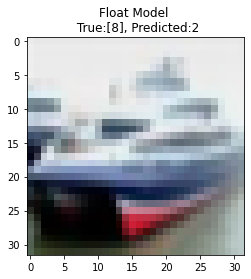

In [20]:
test_model(tflite_model_file, test_image_index, model_type="Float")

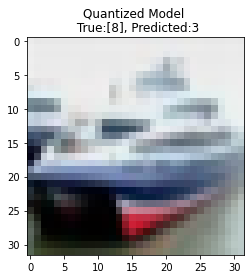

In [21]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

## Pruning 진행



In [22]:
_, baseline_model_accuracy = model.evaluate(
    test_x, test_y, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.10140000283718109
Saved baseline model to: /tmp/tmpwh51ei4r.h5


In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_x.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs


# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_x, train_,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=4,
  validation_split=0.1,
)
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)